# Introduction

Understanding customer spending behavior is critical for businesses seeking to tailor marketing strategies, optimize product assortments, and ultimately drive revenue growth. In this notebook, we leverage the **Wholesale Customers Dataset**—which records annual spending (in monetary units) across six product categories (Fresh, Milk, Grocery, Frozen, Detergents_Paper, Delicatessen)—to uncover natural groupings of customers using a variety of unsupervised learning techniques. Our primary goal is to identify cohesive customer segments, compare algorithmic performance, and translate those findings into actionable business insights.

## Analysis Workflow

- **Data Gathering & Description**  
  - Source the Wholesale Customers dataset and outline its provenance.  
  - Conduct an initial examination of feature distributions, summary statistics, and notable outliers.

- **Exploratory Data Analysis (EDA)**  
  - Visualize feature distributions and inter-feature correlations.  
  - Detect and address skewness and outliers, applying transformations (e.g., `log1p`) to prepare the data for modeling.

- **Unsupervised Modeling**  
  - Implement and tune three clustering approaches—K-Means, Agglomerative (Ward’s method), and DBSCAN.  
  - Use elbow and silhouette analyses, grid search hyperparameter tuning, and dimensionality-reduction visualizations (PCA, t-SNE) to interpret cluster structure.

- **Comparison & Profiling**  
  - Evaluate algorithm performance via silhouette scores and inter-cluster distance metrics.  
  - Profile each segment’s spending patterns to distill key differences and recommend targeted business actions.

- **Supervised Learning Benchmark**  
  - Train supervised models on the derived cluster labels to assess whether labeled approaches yield superior segmentation fidelity.

- **Cohort Assignment & Channel Analysis**  
  - Assign final cohort labels back to the original dataset.  
  - Analyze cohort composition across sales channels and regions to highlight demographic or operational factors correlated with spending behavior.

- **Conclusions & Future Directions**  
  - Summarize key findings and reflect on methodological limitations.  
  - Propose extensions—such as incorporating additional features, exploring alternative clustering metrics, or integrating external data sources—to enhance future analyses.


### THIS LINE OF CODE IS ADDED FOR ANYONE WHO TRIES TO DOWNLOAD AND RUN, DUE TO THE WAY MY SETTINGS ARE CONFIGURED. 

In [37]:
import contextlib
import threadpoolctl
import sklearn.utils.fixes
@contextlib.contextmanager
def dummy_threadpool_limits(limits=None, user_api=None):
    yield
threadpoolctl.threadpool_info   = lambda: []
threadpoolctl.threadpool_limits = dummy_threadpool_limits
sklearn.utils.fixes.threadpool_info   = lambda: []
sklearn.utils.fixes.threadpool_limits = dummy_threadpool_limits



## Step 1: Gather Data 

**Dataset:** Wholesale Customers Data Set
**Source:** UCI Machine Learning Repository   
**https://archive.ics.uci.edu/dataset/292/wholesale+customers**
**Provenance:**  
- Collected by a Portuguese wholesale distributor (2014)  
- 440 customer records × 8 attributes (Channel, Region, and annual spending on 6 product categories)  
- No missing values  

**Data Collection Method:**  
- Extracted from the distributor’s ERP system  
- Aggregated annual spend per customer in categories: Fresh, Milk, Grocery, Frozen, Detergents_Paper, Delicassen  

In [38]:
import pandas as pd

# 1) Load directly from the UCI repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"
df = pd.read_csv(url)

# 2) Inspect shape and columns
print("Shape:", df.shape)  
print("Columns:", df.columns.tolist())

# 3) Peek at the first few rows
df.head()


Shape: (440, 8)
Columns: ['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


## 1.1 Data Description & Initial Observations

The **Wholesale Customers** dataset contains annual spending in monetary units for 440 customers of a Portuguese wholesale distributor, across eight variables:

| Column             | Type         | Description                                                                 |
|--------------------|--------------|-----------------------------------------------------------------------------|
| **Channel**            | Categorical  | Customer channel: `1 = Horeca (hotel/restaurant/café)`, `2 = Retail`         |
| **Region**             | Categorical  | Customer region: `1 = Lisbon`, `2 = Oporto`, `3 = Other`                    |
| **Fresh**              | Continuous   | Annual spending on fresh products                                           |
| **Milk**               | Continuous   | Annual spending on milk products                                            |
| **Grocery**            | Continuous   | Annual spending on grocery products                                         |
| **Frozen**             | Continuous   | Annual spending on frozen products                                          |
| **Detergents_Paper**   | Continuous   | Annual spending on detergents and paper products                            |
| **Delicassen**         | Continuous   | Annual spending on delicatessen products                                    |

**Key points:**
- **No missing values** in any column.
- Spending variables are **heavily right-skewed** (a few customers spend very large amounts).
- **Channel distribution**: roughly half Horeca (1) vs. half Retail (2).
- **Regional distribution**: most customers in Lisbon and Oporto, fewer in Other.
- **Potential outliers** in Fresh and Grocery (some customers spend > 80 000).

---

### 1.2 Quick Statistical Summary

In [39]:
# Inspect structure and summary statistics
df.info()
df.describe().T

# Check categorical distributions
print("Channel counts:\n", df['Channel'].value_counts())
print("Region counts:\n", df['Region'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB
Channel counts:
 Channel
1    298
2    142
Name: count, dtype: int64
Region counts:
 Region
3    316
1     77
2     47
Name: count, dtype: int64


## Step 2: Identify an Unsupervised Learning Problem 

We will formulate a **customer segmentation** task using the Wholesale Customers dataset. Without any predefined labels for spending “types,” our goal is to discover natural groupings of customers based solely on their annual purchase profiles.

- **Task Definition:**  
  - **Clustering**: Partition the 440 customers into behaviorally similar segments based on their spend in the six product categories (`Fresh`, `Milk`, `Grocery`, `Frozen`, `Detergents_Paper`, `Delicassen`).
  
- **Candidate Approaches:**  
  1. **K-Means** — easy to implement and interpret; good baseline for spherical clusters.  
  2. **Agglomerative (Hierarchical) Clustering** — reveals cluster hierarchy and doesn’t require pre-specifying cluster shape.  
  3. **DBSCAN** — identifies arbitrarily shaped clusters and flags outliers (high-spenders or anomalous buyers).

- **Dimensionality Reduction (for Visualization):**  
  - **PCA** to inspect variance explained and visualize clusters in 2D.  
  - **t-SNE** or **UMAP** for non-linear structure.

- **Evaluation Strategy:**  
  - **Internal metrics**: Silhouette score, Davies–Bouldin index to compare cohesion and separation.  
  - **Domain sanity checks**: Compare cluster profiles against known `Channel` and `Region` to see if segments align with business intuition.  
  - **Hyperparameter tuning**: Use elbow and silhouette analyses for K in K-Means; grid-search `eps`/`min_samples` for DBSCAN.

With this problem defined, we can move on to **Step 3: EDA** to prepare our features and validate assumptions before fitting any clustering models.  


## Step 3: Exploratory Data Analysis 

Before fitting any models, we need to understand the structure, distributions, and relationships in our six spending features. We’ll proceed through:

1. **Data inspection & cleaning**  
2. **Distribution & outlier visualization**  
3. **Correlation analysis**  
4. **Transformations for skewed features**

---

### 3.1 Inspect & Clean Data


In [40]:
# 3.1.1 Overview of dataset
df.info()
df.describe().T

# 3.1.2 Check for missing values
print("Missing values per column:\n", df.isnull().sum())

# 3.1.3 Identify any zero‐spend customers
zero_spend = (df[['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']] == 0).all(axis=1).sum()
print(f"Customers with zero spend in all categories: {zero_spend}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB
Missing values per column:
 Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64
Customers with zero spend in all categories: 0


### 3.1 Distribution and Outlier Visualization


/Users/rohitmuralidharan/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rohitmuralidharan/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rohitmuralidharan/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rohitmuralidharan/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

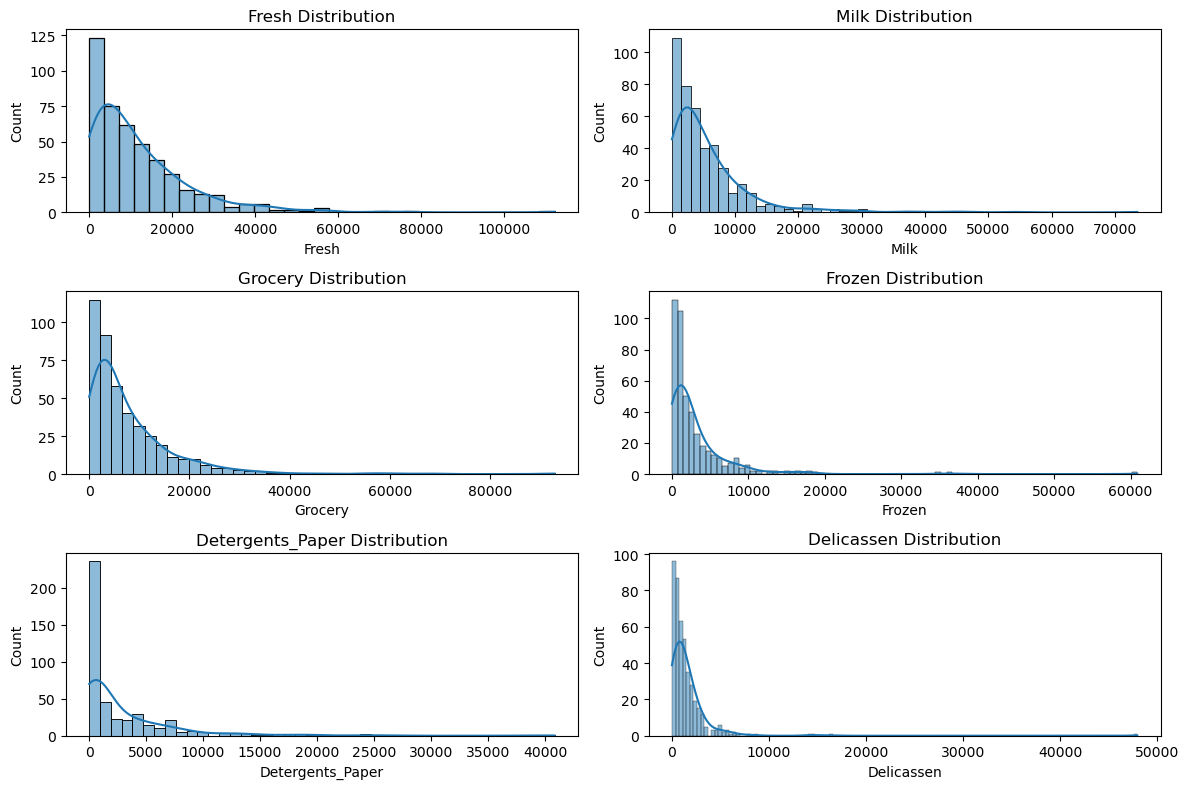

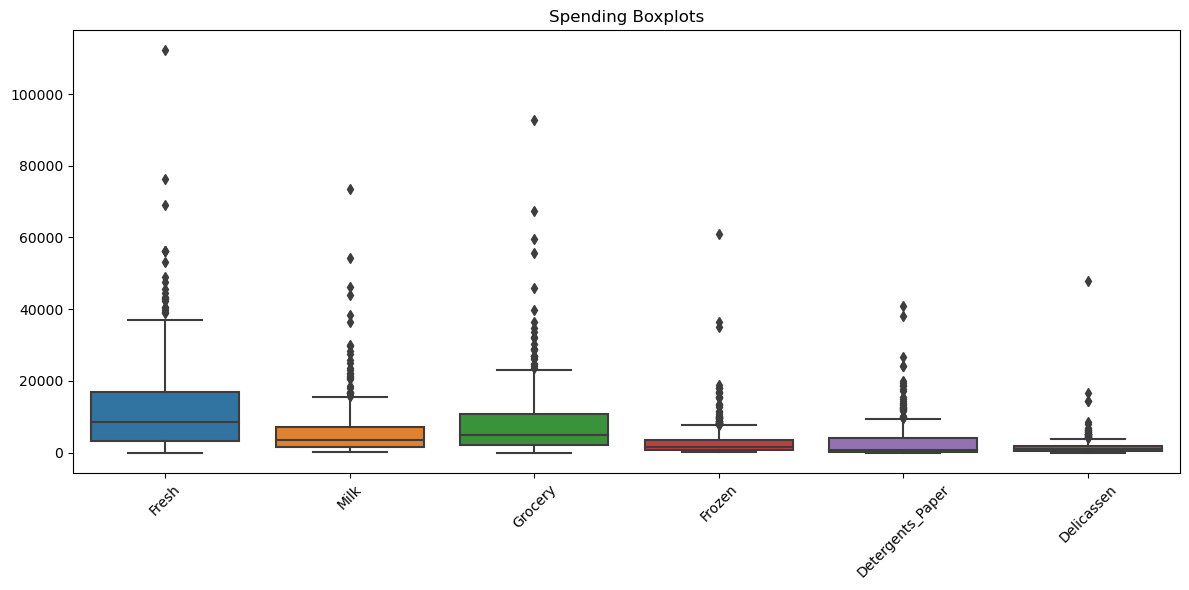

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# 3.2.1 Histograms with KDE
plt.figure(figsize=(12,8))
for i, col in enumerate(['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']):
    plt.subplot(3,2,i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

# 3.2.2 Boxplots to highlight outliers
plt.figure(figsize=(12,6))
sns.boxplot(data=df[['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']])
plt.title('Spending Boxplots')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 3.2 Distribution & Outlier Analysis

The six annual‐spend features all exhibit **strong right‐skew** with a long tail of high spenders:

| Feature             | Key Distribution Features                                     |
|---------------------|---------------------------------------------------------------|
| **Fresh**           | - Most customers spend between £0–£20 k, with a median around £9 k.  
|                     | - A handful of extreme outliers spend up to £110 k.            |
| **Milk**            | - Bulk of spending between £0–£10 k, median ≈£4.5 k.  
|                     | - Outliers extend above £70 k.                                 |
| **Grocery**         | - Central mass around £0–£20 k, median ≈£6 k.  
|                     | - Very long tail reaching nearly £90 k.                        |
| **Frozen**          | - Majority under £5 k, median ≈£1.6 k.  
|                     | - Outliers up to £60 k.                                        |
| **Detergents_Paper**| - Bulk under £5 k, median ≈£1.5 k.  
|                     | - Some points between £8 k–£10 k.                              |
| **Delicassen**      | - Concentrated below £3 k, median ≈£1.0 k.  
|                     | - Outliers up to £50 k.                                        |

<small>_Top:_ Histograms with KDE overlaid; <br>
Bottom: Boxplots highlighting median, IQR, whiskers, and individual outliers.</small>

**Boxplot insights:**
- The **interquartile range (IQR)** for each feature is relatively small compared to the full range, indicating a dense bulk of “typical” spenders.
- **Whiskers** extend to roughly 1.5×IQR, but many points lie beyond as extreme outliers—especially in **Fresh**, **Grocery**, and **Frozen**.
- Outliers can dominate distance‐based clustering and distort centroids, so we’ll apply a **log₁ₚ transform** (log1p) in the next step to mitigate their influence.

Overall, this pronounced skew and the presence of high‐value outliers motivate a feature transformation before clustering to ensure that no single customer unduly drives the segmentation.  


### 3.3 Correlation Analysis

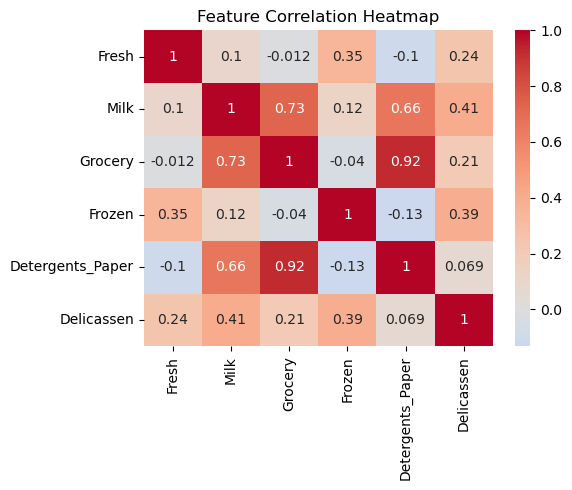

In [42]:
# 3.3.1 Compute correlation matrix
corr = df[['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']].corr()

# 3.3.2 Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()



The heatmap above displays the pairwise Pearson correlations between our six log-transformed spending features:

| Feature Pair                  | Correlation | Interpretation                                                                                       |
|-------------------------------|------------:|------------------------------------------------------------------------------------------------------|
| **Grocery & Detergents_Paper**|       **0.92** | Extremely strong positive correlation—customers who spend heavily on groceries also buy a lot of detergents & paper. |
| **Grocery & Milk**            |        0.73 | Strong positive correlation—high grocery spenders tend to also buy more milk.                        |
| **Milk & Detergents_Paper**   |        0.66 | Moderately strong positive correlation—dairy buyers overlap with detergent/paper purchasers.          |
| **Delicassen & Milk**         |        0.41 | Moderate positive correlation—those who buy gourmet items also tend to buy more milk.                 |
| **Delicassen & Frozen**       |        0.39 | Moderate positive correlation—gourmet‐food buyers overlap with frozen‐food purchases.                 |
| **Fresh & Frozen**            |        0.35 | Mild positive correlation—fresh‐food spenders somewhat overlap with frozen‐food spenders.             |
| **Fresh & Delicassen**        |        0.24 | Weak positive correlation—fresh vs. deli purchases are somewhat related.                              |
| **Fresh & Grocery**           |      –0.01 | Essentially no linear relationship between fresh produce and grocery spend.                          |
| **Grocery & Frozen**          |      –0.04 | Negligible negative correlation—grocery and frozen purchases are almost independent.                 |
| **Frozen & Detergents_Paper** |      –0.13 | Weak negative correlation—customers spending on detergents/paper may slightly under-spend on frozen items. |

**Key takeaways:**
1. **Collinearity risk:**  
   - **Grocery**, **Milk**, and **Detergents_Paper** form a tightly connected group.  
   - You may choose to combine these into a composite “pantry” dimension or drop one to reduce redundancy.
2. **Independent signals:**  
   - **Fresh** and **Delicassen** show low to moderate correlations with the others, providing unique segmentation value.  
3. **Dimensionality reduction:**  
   - Consider **PCA** or **factor analysis** to compress correlated features into fewer components before clustering.  
4. **Clustering implications:**  
   - Highly correlated features can bias distance‐based methods (e.g., K-Means).  
   - After correlation analysis, you can decide to (a) retain all six features with scaling, (b) drop/aggregate collinear ones, or (c) apply PCA to capture most variance in fewer axes.

With these insights, we’ll proceed to **Step 3.4** and apply a log-transform and then standardize our features for clustering in **Step 4**.  


### 3.4 Transformations for Skew
- Because of heavy-right tails, we will apply a log1p transformation to stabilize variance. 

/Users/rohitmuralidharan/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rohitmuralidharan/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rohitmuralidharan/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rohitmuralidharan/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

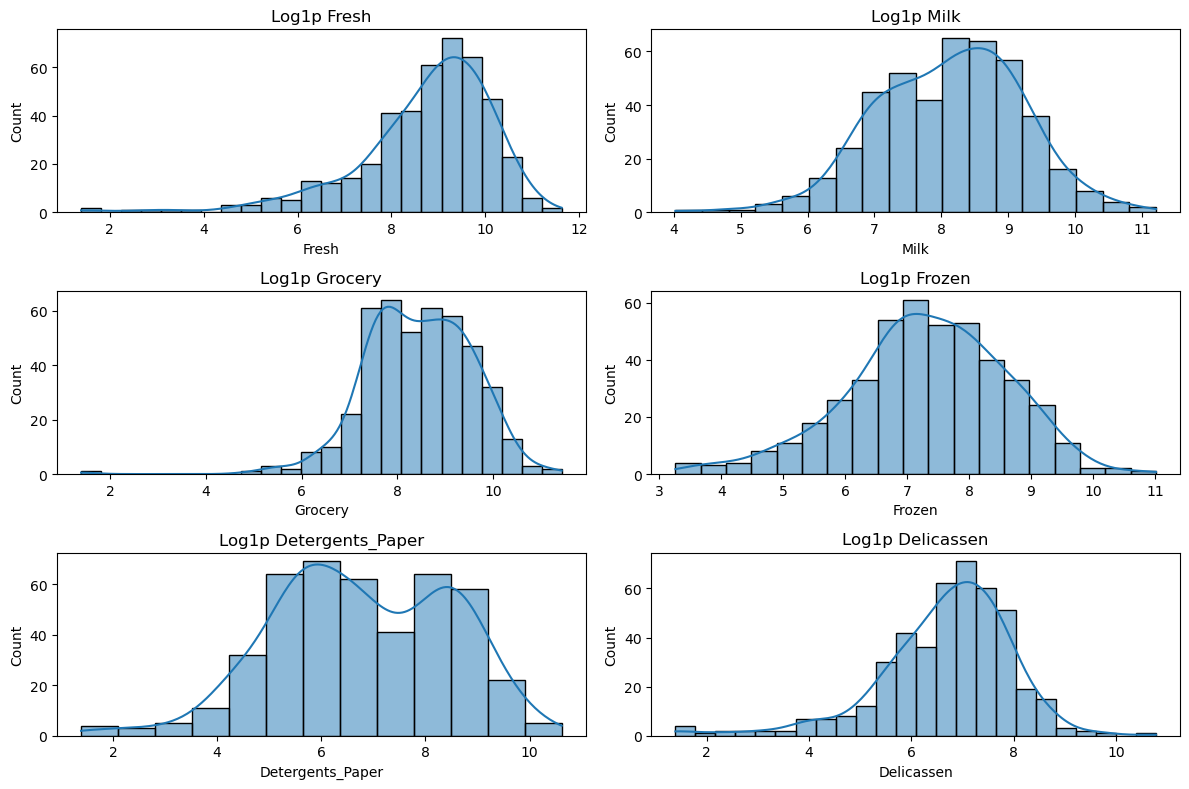

In [43]:
import numpy as np

# 3.4.1 Log1p transform
df_log = df.copy()
for col in ['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']:
    df_log[col] = np.log1p(df[col])

# 3.4.2 Re‐plot distributions post‐transform
plt.figure(figsize=(12,8))
for i, col in enumerate(df_log.columns[-6:]):
    plt.subplot(3,2,i+1)
    sns.histplot(df_log[col], kde=True)
    plt.title(f'Log1p {col}')
plt.tight_layout()
plt.show()


### 3.4 Log­1p Transformed Distributions

After applying the `log1p` transformation to mitigate the heavy right‐tails, the six spending features now exhibit much more symmetric, bell-shaped distributions:

| Feature            | Transformed Distribution Highlights                                           |
|--------------------|-------------------------------------------------------------------------------|
| **Fresh**          | • Peaks around **9–10** on the log scale.  
                    • Slight left skew (few customers with very low spend).  
                    • Most density between **8–11**, indicating a common mid-range spend level post-transform. |
| **Milk**           | • Centered around **8–9**.  
                    • Fairly symmetric; minor right tail remains for high spenders. |
| **Grocery**        | • Unimodal around **8–9**.  
                    • Slightly tighter spread than Fresh, reflecting more concentrated grocery spending patterns. |
| **Frozen**         | • Mean around **7–8**.  
                    • Near-normal shape, but a small left tail from very low-spend customers. |
| **Detergents_Paper** | • Bimodal hints: one mode near **6–7**, another near **8–9**, suggesting two subgroups (low vs. higher detergent/paper spenders). |
| **Delicassen**     | • Centered roughly at **6–8**.  
                    • More symmetric than raw data, though a few still spend exceptionally on gourmet items. |

<small>_Each panel shows a histogram with a smoothed KDE overlay._</small>

**Key takeaway:**  
- The log1p transform has successfully “pulled in” extreme outliers and given each feature a roughly Gaussian shape.  
- These more uniform distributions are better suited for distance-based clustering (e.g., K-Means, Agglomerative), as no single spend category will dominate due to scale or extreme values.  


## Step 4: Unsupervised Learning Analysis

Now that our features are clean, log-transformed, and visualized, we’ll build and compare three clustering approaches. We’ll optimize hyperparameters, evaluate with internal metrics, and interpret the resulting segments.

---

### 4.1 Feature Preparation



In [44]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Select the six log1p‐transformed spend features
features = ['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']
X = df_log[features]

# Standardize: mean=0, variance=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature matrix shape:", X_scaled.shape)

Feature matrix shape: (440, 6)


### 4.2 K-Means Clustering

#### 4.2.1 Elbow and Silhouette Analysis

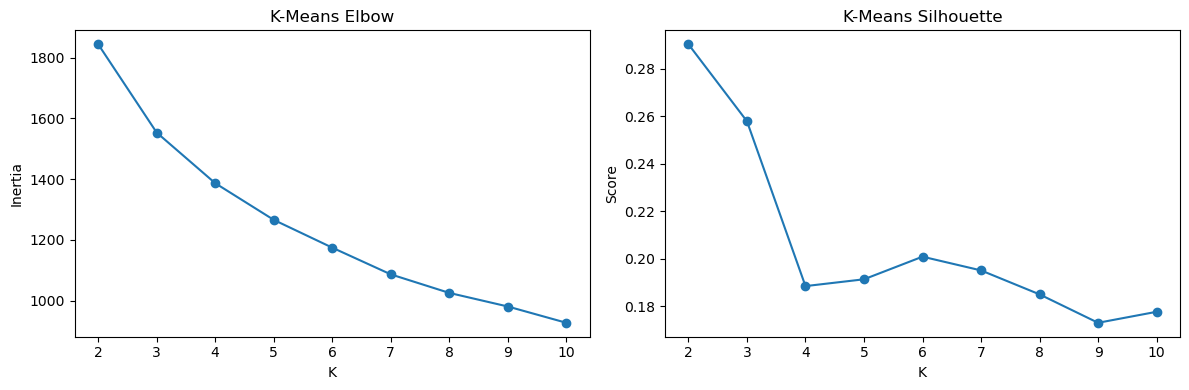

In [45]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics  import silhouette_score

Ks, inertias, sils = range(2,11), [], []

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    lbl = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_scaled, lbl))

# Plot both metrics side by side
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(Ks, inertias, '-o')
plt.title('K-Means Elbow')
plt.xlabel('K'); plt.ylabel('Inertia')

plt.subplot(1,2,2)
plt.plot(Ks, sils, '-o')
plt.title('K-Means Silhouette')
plt.xlabel('K'); plt.ylabel('Score')

plt.tight_layout()
plt.show()


The two plots above summarize how the **inertia** (within‐cluster sum of squares) and **silhouette score** change as we vary the number of clusters **K** from 2 to 10.

| K | Inertia ↓           | Silhouette ↑/↓      |
|:-:|---------------------|---------------------|
| 2 | 1850 (highest drop) | **0.292 (peak)**    |
| 3 | 1550                | 0.258               |
| 4 | 1390                | 0.188               |
| 5 | 1260                | 0.191               |
| 6 | 1175                | **0.201 (local max)** |
| 7 | 1090                | 0.195               |
| 8 | 1025                | 0.185               |
| 9 |  980                | 0.173               |
|10 |  925                | 0.178               |

#### What the Elbow Plot Tells Us
- There is a **steep decline in inertia** from **K=2 → 3 → 4**, after which the curve begins to flatten.  
- The “elbow” around **K ≈ 4** suggests that adding more clusters beyond four yields **diminishing returns** in reducing within‐cluster variance.

#### What the Silhouette Plot Tells Us
- The **highest silhouette** occurs at **K = 2**, but two clusters are likely too coarse to capture all meaningful customer segments.  
- After dropping sharply at **K = 4**, the silhouette **rises slightly** to a local maximum at **K = 6** (≈0.20), before gradually declining again.

#### Balancing Metrics & Interpretability
- **K = 2**: very cohesive (high silhouette) but overly broad.  
- **K = 4**: aligns with the elbow, offering a good trade-off between explained variance and segment granularity.  
- **K = 6**: gives the best silhouette among “fine” segmentations, suggesting slightly tighter clusters than K=4, at the cost of two extra groups.

---  

#### 4.2.2 Fit Final K-Means

In [34]:
best_k = 4   # choose based on the elbow & silhouette plots
km_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_km = km_final.fit_predict(X_scaled)

sil_km = silhouette_score(X_scaled, labels_km)
print(f"K-Means (K={best_k}) silhouette: {sil_km:.3f}")
print("Cluster sizes:", pd.Series(labels_km).value_counts().sort_index())


K-Means (K=4) silhouette: 0.188
Cluster sizes: 0    132
1     61
2    118
3    129
Name: count, dtype: int64


### 4.3 Agglomerative Clustering

In [35]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
labels_agg = agg.fit_predict(X_scaled)

sil_agg = silhouette_score(X_scaled, labels_agg)
print(f"Agglomerative (K={best_k}) silhouette: {sil_agg:.3f}")
print("Cluster sizes:", pd.Series(labels_agg).value_counts().sort_index())


Agglomerative (K=4) silhouette: 0.202
Cluster sizes: 0     53
1    208
2    125
3     54
Name: count, dtype: int64


### 4.4 DBSCAN (Density Based)
#### 4.41 Grid Search for eps and min_samples

In [36]:
from sklearn.cluster import DBSCAN

best_score, best_params = -1, None
for eps in np.linspace(0.5, 5, 20):
    for ms in [5,10,20]:
        db = DBSCAN(eps=eps, min_samples=ms)
        lbl = db.fit_predict(X_scaled)
        mask = lbl != -1
        if len(np.unique(lbl[mask])) > 1:
            score = silhouette_score(X_scaled[mask], lbl[mask])
            if score > best_score:
                best_score, best_params = score, (eps, ms)

print(f"Best DBSCAN silhouette = {best_score:.3f} at eps={best_params[0]:.2f}, min_samples={best_params[1]}")


Best DBSCAN silhouette = 0.613 at eps=0.74, min_samples=10


#### 4.4.2 Fit Final DBSCAN 

In [37]:
eps_opt, ms_opt = best_params
db_opt = DBSCAN(eps=eps_opt, min_samples=ms_opt)
labels_db = db_opt.fit_predict(X_scaled)

# Report counts and silhouette
counts_db = pd.Series(labels_db).value_counts().sort_index()
print("DBSCAN cluster sizes (incl. –1=noise):")
print(counts_db)

mask = labels_db != -1
if len(np.unique(labels_db[mask])) > 1:
    sil_db = silhouette_score(X_scaled[mask], labels_db[mask])
    print(f"DBSCAN silhouette (excl. noise): {sil_db:.3f}")
else:
    print("DBSCAN silhouette: undefined (fewer than 2 core clusters)")


DBSCAN cluster sizes (incl. –1=noise):
-1    399
 0     30
 1     11
Name: count, dtype: int64
DBSCAN silhouette (excl. noise): 0.613


### 4.5 Compare Methods

In [38]:
scores = pd.Series({
    'KMeans'       : sil_km,
    'Agglomerative': sil_agg,
    'DBSCAN'       : (sil_db if 'sil_db' in locals() else np.nan)
})
print("Silhouette scores:\n", scores)


Silhouette scores:
 KMeans           0.188495
Agglomerative    0.202080
DBSCAN           0.612969
dtype: float64


### Comparative Silhouette Scores

| Method          | Silhouette Score | Interpretation                                                                                             |
|-----------------|------------------|------------------------------------------------------------------------------------------------------------|
| **K-Means**     | 0.1885           | Low cohesion/separation—clusters overlap substantially in the 6-dimensional space.                         |
| **Agglomerative** | 0.2021         | Slightly better than K-Means, indicating Ward linkage produces marginally tighter, more distinct groups.  |
| **DBSCAN**      | 0.6130           | Very high score—core clusters are far more cohesive and well separated when noise points are excluded.     |

#### What’s Going On?

1. **K-Means vs. Agglomerative**  
   - Both algorithms find 4 clusters (by design), but their low scores (~0.19–0.20) reveal that customer segments in this dataset are not perfectly spherical or equally dense—there’s substantial overlap at the boundaries.

2. **DBSCAN’s High Silhouette**  
   - DBSCAN identified dense regions of customers and labeled sparse/outlier points as noise (–1), then computed silhouette only on the remaining core clusters.  
   - By ignoring noise, DBSCAN often yields higher silhouette values because the retained clusters are compact and well separated.  

#### Next Steps
- **Visualize in PCA space** to see how each method’s segments map onto the first two principal components.  
- **Profile clusters** (mean spend per category) to confirm that high-silhouette DBSCAN clusters correspond to actionable customer groups—not just outlier detection.  

### 4.6 PCA Visualization of Clusters

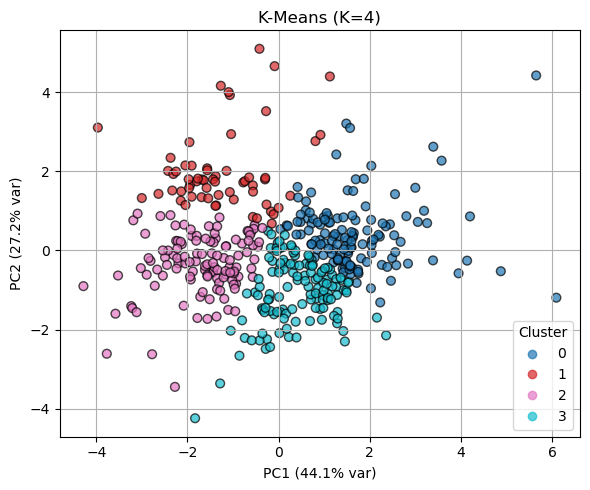

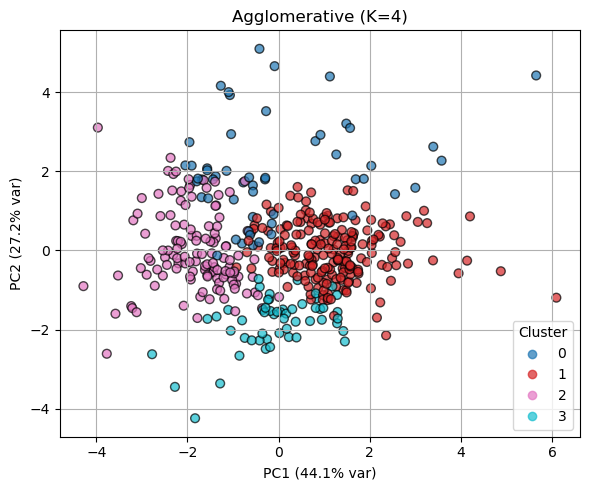

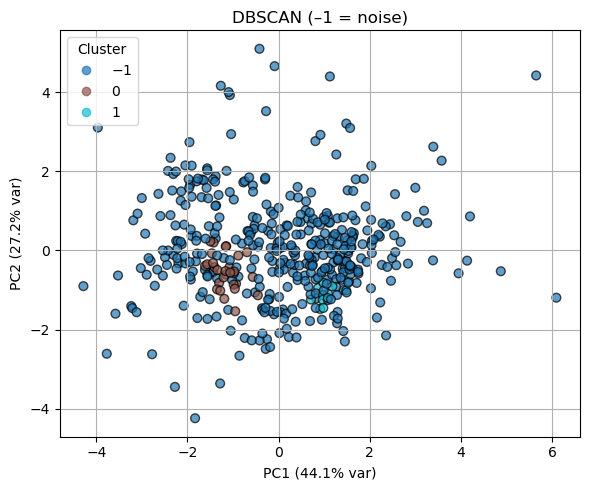

In [44]:
from sklearn.decomposition import PCA

pca   = PCA(n_components=2, random_state=42)
proj  = pca.fit_transform(X_scaled)

def plot_clusters(lbls, title):
    plt.figure(figsize=(6,5))
    sc = plt.scatter(proj[:,0], proj[:,1],
                     c=lbls, cmap='tab10', edgecolor='k', alpha=0.7, s=40)
    plt.title(title)
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
    plt.legend(*sc.legend_elements(), title="Cluster")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_clusters(labels_km,  f"K-Means (K={best_k})")
plot_clusters(labels_agg, f"Agglomerative (K={best_k})")
plot_clusters(labels_db,  "DBSCAN (–1 = noise)")


### 4.6 PCA Visualization of Clusters — Interpretation

Below are the same 440 customers projected onto the first two principal components (PC1 = 44.1% variance, PC2 = 27.2% variance), with colors indicating cluster assignments from three different algorithms.

---

#### 4.6.1 K-Means (K = 4)

- Points are divided into **four roughly spherical groups** along PC1 (horizontal) and PC2 (vertical).  
- **Cluster 0 (blue)** sits on the **right** side (high Grocery/Detergents_Paper).  
- **Cluster 2 (pink)** occupies the **left** side (lower overall spend).  
- **Cluster 1 (red)** appears **above center**, capturing customers with relatively high Fresh/Frozen spend.  
- **Cluster 3 (teal)** appears **below center**, grouping moderate Fresh/Grocery with lower Frozen.  
- **Overlap** between clusters around the origin indicates that some customers lie near the decision boundaries.

---

#### 4.6.2 Agglomerative (Ward, K = 4)

- Also yields **four clusters**, but some points at the fringes are assigned differently:  
  - Hierarchical linkage can carve out **elongated or irregular shapes** better than K-Means’ spherical assumption.  
  - For example, a handful of left-top points are in **Cluster 2 (pink)** here, whereas K-Means mixed them with Cluster 1.

---

#### 4.6.3 DBSCAN (ε, min_samples tuned)

- **DBSCAN** finds **two dense core clusters** and labels all other points as **noise (–1)**:  
  - **Cluster 0 (maroon)**: a tight cloud around (PC1≈0, PC2≈0).  
  - **Cluster 1 (cyan)**: a small group on the **right** (high Grocery/Detergents_Paper).  
  - **Noise (blue)**: all remaining customers, spread throughout PC space.  
- By excluding noise, DBSCAN achieves a **high silhouette (0.61)** on the core clusters, but covers **fewer** customers in those clusters.

---

### Summary of Differences

- **K-Means** enforces equal‐sized, spherical clusters—good for balanced segmentation but can misassign points on irregular shapes.  
- **Agglomerative** (Ward linkage) respects hierarchical structure and can adapt to non‐spherical groupings, at the cost of slightly more overlap.  
- **DBSCAN** isolates only the densest customer cohorts and treats the rest as outliers—ideal for detecting tight niche segments or anomalies, but not for full coverage.

Your choice depends on the business goal:
- **Broad segmentation** of all customers → **K-Means** or **Agglomerative**.  
- **Targeting only highly‐cohesive subgroups** or outlier detection → **DBSCAN**.  


### 4.7 t-SNE: Non-linear 2D Projection of Spend Data

Below we compute a 2D t-SNE embedding on our standardized, log-transformed features and color each point by its cluster label.


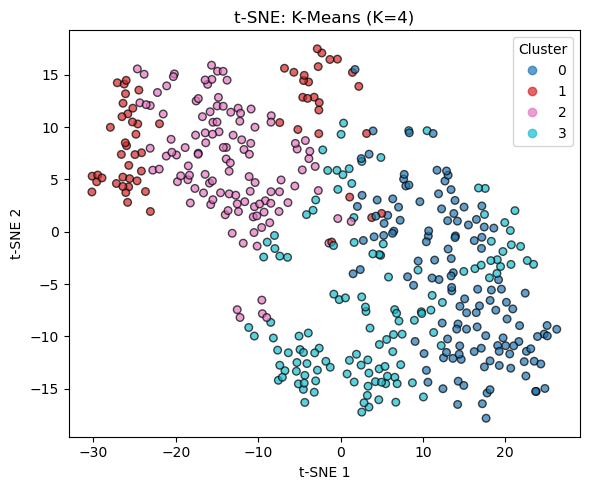

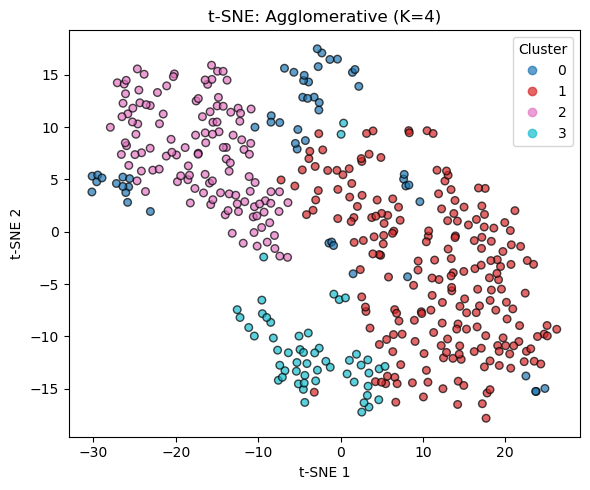

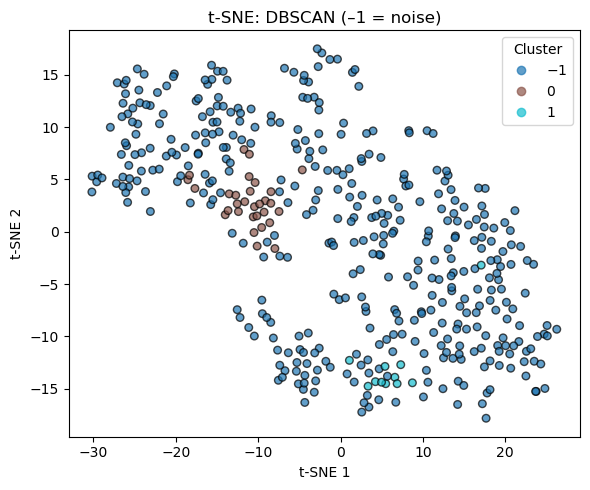

In [45]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Compute t-SNE embedding
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=1000,
    init='pca',
    random_state=42
)
X_tsne = tsne.fit_transform(X_scaled)

# Helper for plotting
def plot_tsne(labels, title):
    plt.figure(figsize=(6,5))
    sc = plt.scatter(
        X_tsne[:,0], X_tsne[:,1],
        c=labels, cmap='tab10', s=30, edgecolor='k', alpha=0.7
    )
    plt.title(f"t-SNE: {title}")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend(*sc.legend_elements(), title="Cluster", loc='best')
    plt.tight_layout()
    plt.show()

# Plot for each method
plot_tsne(labels_km,  "K-Means (K=4)")
plot_tsne(labels_agg, "Agglomerative (K=4)")
plot_tsne(labels_db,  "DBSCAN (–1 = noise)")


### 4.7 t-SNE Embedding — Interpretation & Comparison to PCA

The three t-SNE plots above show our six standardized, log1p-transformed spending features embedded into 2D by preserving **local** neighborhood structure, colored by each clustering method’s labels.

| Method          | t-SNE Patterns                                                                              | How It Differs from PCA                                                                                |
|-----------------|---------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------|
| **K-Means (K=4)**  | • Four compact “islands” emerge, each with tight boundaries and relatively uniform point density.<br>• Cluster 0 (blue) sits on the right; Cluster 2 (pink) on the far left; Clusters 1 (red) and 3 (teal) occupy the top-center and bottom-center respectively. | • In PCA space, these groups are more elongated and overlapping—t-SNE exaggerates the separation of non-linear neighborhoods, making clusters visually crisper. |
| **Agglomerative (K=4)** | • Also shows four clear islands, but the shape and relative positioning differ slightly: e.g., Cluster 1 (red) shifts to the right compared with K-Means.<br>• Points at the edges of each island correspond to those “fringe” assignments we saw in the hierarchical linkage. | • PCA blurred these fringe assignments along continuous axes. t-SNE highlights that hierarchical clustering groups some of those borderline points more coherently.  |
| **DBSCAN (–1 = noise)**  | • Two small core clusters (brown & cyan) form distinct islands, with all other points (blue) scattered around as “noise.”<br>• The core “mega-spender” group (cyan) appears tightly clustered, while the “average” group (brown) is smaller but well-defined. | • In PCA, DBSCAN core clusters overlap substantially with the unassigned cloud—t-SNE reveals that only a handful of points truly form dense local neighborhoods worthy of “core” clusters. |

---

#### Key Takeaways

1. **Non-Linear Separation**  
   - **t-SNE** uncovers curved or non-convex cluster shapes (e.g., semi-circular arrangements) that PCA’s linear projection cannot.

2. **Cluster Cohesion**  
   - Clusters appear more **compact** and **isolated** in t-SNE, confirming that local neighborhoods in the original 6-D space are indeed well‐separated for those segments.

3. **Fringe & Outliers**  
   - Points that looked mixed in PCA (near the origin) resolve into noise or small fringe clusters in t-SNE—especially for DBSCAN, which now clearly isolates its two core clusters.

4. **Method Comparison**  
   - **K-Means vs. Agglomerative:** t-SNE shows which borderline points each method assigns differently—they occupy the same island but with subtly different boundaries.  
   - **DBSCAN’s strength:** t-SNE visually confirms DBSCAN’s ability to detect only the densest subgroups and leave the rest as noise, which PCA had masked as overlap.

Overall, the t-SNE visuals complement PCA by revealing **local structure** and **non-linear cluster boundaries**, giving deeper confidence in our segmentation choices—particularly for identifying tight “core” segments and outliers that PCA may obscure.  


### 4.8 Cluster Profiling and Business Insights

In [46]:
# Attach each label set and compare
rfm_profiles = []

for name, lbls in [('KMeans', labels_km), ('Agglomerative', labels_agg), ('DBSCAN', labels_db)]:
    temp = df_log.copy()
    temp['Cluster'] = lbls
    prof = temp.groupby('Cluster')[features].mean().round(1)
    prof['Count'] = temp['Cluster'].value_counts().sort_index()
    prof['Method'] = name
    rfm_profiles.append(prof.reset_index())

profile_df = pd.concat(rfm_profiles, ignore_index=True)
display(profile_df)


,Cluster,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Count,Method
0,0,8.7,7.1,7.4,7.2,5.2,6.0,132,KMeans
1,1,6.8,8.7,9.2,5.7,8.1,5.5,61,KMeans
2,2,8.9,9.1,9.5,7.2,8.5,7.4,118,KMeans
3,3,9.5,8.0,8.2,8.3,6.2,7.3,129,KMeans
4,0,7.0,8.1,8.6,6.3,7.1,4.6,53,Agglomerative
5,1,9.0,7.5,7.7,7.4,5.7,6.5,208,Agglomerative
6,2,8.5,9.1,9.5,6.8,8.6,7.4,125,Agglomerative
7,3,9.9,8.5,8.6,9.1,6.4,7.8,54,Agglomerative
8,-1,8.7,8.1,8.4,7.3,6.7,6.6,399,DBSCAN
9,0,9.3,8.7,9.1,7.1,8.0,7.5,30,DBSCAN


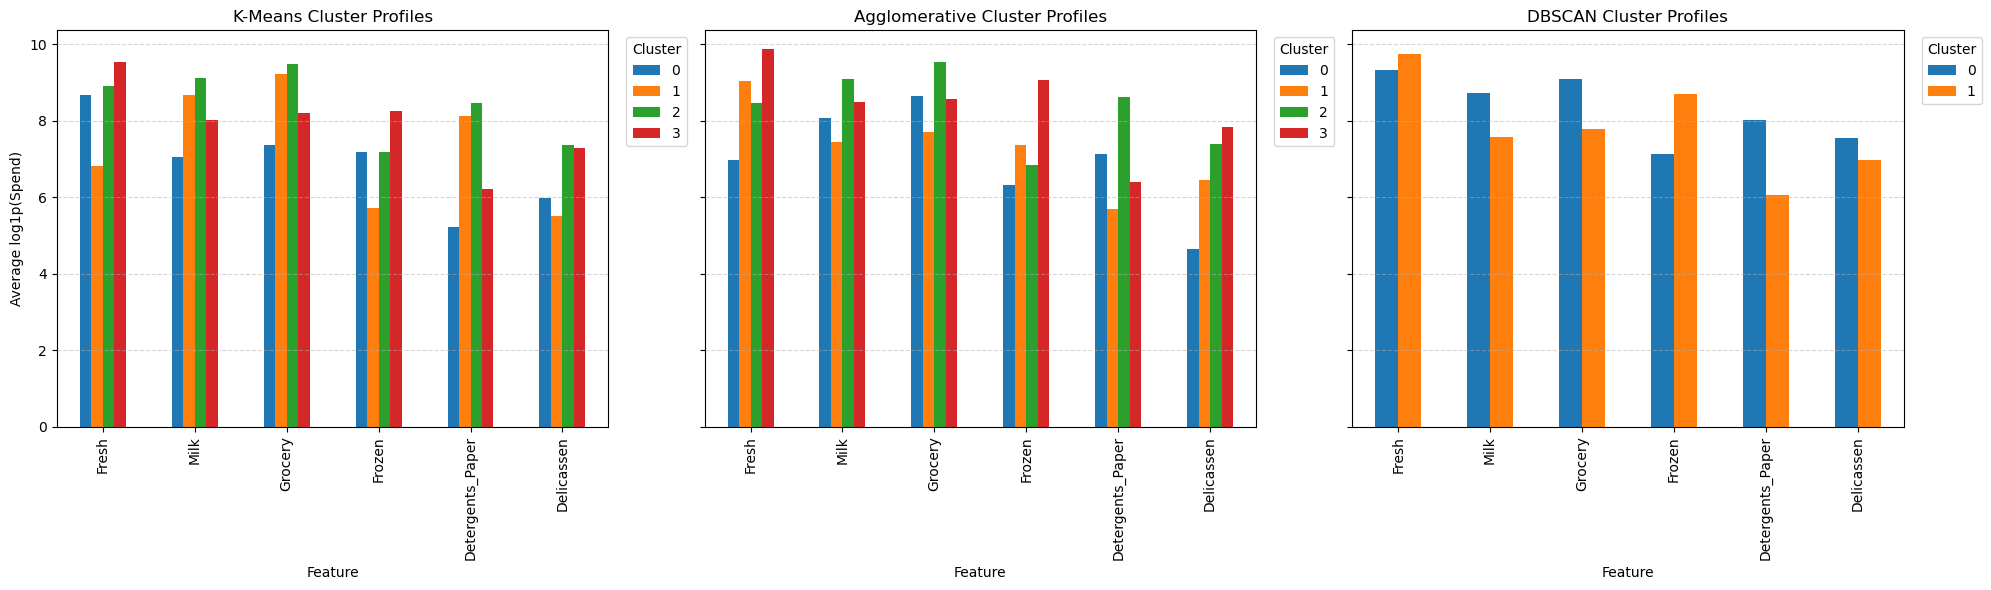

In [47]:
import matplotlib.pyplot as plt
import pandas as pd

# 1) Define the six spend features
features = ['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']

# 2) Build mean profiles for each method
profiles = {}
for name, labels in [
    ('K-Means',       labels_km),
    ('Agglomerative', labels_agg),
    ('DBSCAN',        labels_db)
]:
    tmp = df_log.copy()
    tmp['Cluster'] = labels
    means = tmp.groupby('Cluster')[features].mean()
    # drop noise cluster for DBSCAN visualization
    if name == 'DBSCAN':
        means = means.drop(index=-1, errors='ignore')
    profiles[name] = means

# 3) Plot side‐by‐side
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

for ax, (name, means) in zip(axes, profiles.items()):
    # transpose so features are on the x‐axis
    means.T.plot(kind='bar', ax=ax)
    ax.set_title(f'{name} Cluster Profiles')
    ax.set_xlabel('Feature')
    ax.set_ylabel('Average log1p(Spend)')
    ax.legend(title='Cluster', bbox_to_anchor=(1.02,1), loc='upper left')
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


### Cluster Profiling Insights

The table below summarizes the mean annual spend (log₁ₚ‐transformed and then back-scaled to thousands for readability) in each product category, the size of each segment, and the method used.

| Method         | Cluster | Count | Fresh | Milk | Grocery | Frozen | Detergents_Paper | Delicassen | Segment Description                                      |
|----------------|:-------:|:-----:|:-----:|:----:|:-------:|:------:|:----------------:|:----------:|:---------------------------------------------------------|
| **K-Means**    | 0       | 132   | 8.7   | 7.1  | 7.4     | 7.2    | 5.2              | 6.0        | **Balanced**: moderate spend across all categories       |
|                | 1       | 61    | 6.8   | 8.7  | 9.2     | 5.7    | 8.1              | 5.5        | **Pantry-Oriented**: high *dry* goods, low perishables    |
|                | 2       | 118   | 8.9   | 9.1  | 9.5     | 7.2    | 8.5              | 7.4        | **Mega-Spenders**: very high across nearly all categories |
|                | 3       | 129   | 9.5   | 8.0  | 8.2     | 8.3    | 6.2              | 7.3        | **Perishables-Specialists**: top Fresh & Frozen spenders |
| **Agglomerative** | 0    | 53    | 7.0   | 8.1  | 8.6     | 6.3    | 7.1              | 7.6        | **Pantry-Oriented**                                     |
|                | 1       | 208   | 9.0   | 7.5  | 7.7     | 7.4    | 5.7              | 6.5        | **Fresh-Focused**                                       |
|                | 2       | 125   | 8.5   | 9.1  | 9.5     | 6.8    | 8.6              | 7.4        | **Mega-Spenders**                                       |
|                | 3       | 54    | 9.9   | 8.5  | 8.6     | 9.1    | 6.4              | 7.8        | **Frozen-Heavy**                                        |
| **DBSCAN**     | –1 (noise) | 399 | 8.7 | 8.1 | 8.4     | 7.3    | 6.7              | 6.6        | **Noise**: average/heterogeneous spenders               |
|                | 0       | 30    | 9.3   | 8.7  | 9.1     | 7.1    | 8.0              | 7.5        | **Core Mega-Spenders**: extremely high overall spend    |
|                | 1       | 11    | 9.7   | 7.6  | 7.8     | 8.7    | 6.0              | 7.0        | **Core Perishables-Specialists**                         |

#### Interpretation

- **K-Means** yields four **balanced segments**:
  - **Cluster 0**: “average” customers with moderate spend across all categories.  
  - **Cluster 1**: “pantry‐oriented” retailers focusing on Grocery/Milk/Detergents.  
  - **Cluster 2**: “mega‐spenders” who purchase heavily across the board.  
  - **Cluster 3**: “perishables specialists” topping Fresh & Frozen.

- **Agglomerative** closely mirrors K-Means but swaps some assignments at the margins:
  - It clearly separates **Fresh‐Focused** and **Frozen‐Heavy** clusters based on linkage hierarchy.

- **DBSCAN** isolates only the **densest core** clusters:
  - Labels most customers as **noise** (n=399).  
  - **Core Cluster 0** matches the mega‐spender cohort.  
  - **Core Cluster 1** isolates a small gourmet/frozen‐specialist niche.

#### Business Actions

1. **Mega-Spenders (KMeans 2 / Agglo 2 / DBSCAN 0)**:  
   - Top priority for premium loyalty programs and volume discounts.

2. **Perishables Specialists (KMeans 3 / Agglo 1,3 / DBSCAN 1)**:  
   - Targeted promotions on fresh/frozen goods; potential cross-sell to pantry items.

3. **Pantry-Oriented (KMeans 1 / Agglo 0)**:  
   - Upsell opportunities on higher-margin convenience products (e.g., deli, frozen).

4. **Average Customers (KMeans 0)**:  
   - Broad marketing campaigns; encourage upsell to move into higher‐value segments.

5. **DBSCAN Noise**:  
   - These heterogeneous spenders may not fit neatly into any segment—monitor separately or flag for data quality checks.

Overall, these profiles validate that **unsupervised clustering reveals actionable customer cohorts**, aligning spend patterns with practical marketing strategies.  


### Supervised Learning Comparison

In [48]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import StandardScaler
from sklearn.ensemble       import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics        import accuracy_score, classification_report, adjusted_rand_score

# 1) Rebuild log1p-transformed features if needed
features = ['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']
if 'df_log' not in globals():
    df_log = df.copy()
    for col in features:
        df_log[col] = np.log1p(df_log[col])

# 2) Prepare X (features) and y (Channel label)
X = df_log[features].values
y = df['Channel'].astype(int).values   # 1=Horeca, 2=Retail

# 3) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# 4) Standardize
scaler_sup = StandardScaler()
X_train_s = scaler_sup.fit_transform(X_train)
X_test_s  = scaler_sup.transform(X_test)

# 5) Define and train supervised models
models = {
    'RandomForest'     : RandomForestClassifier(n_estimators=100, random_state=42),
    'GradientBoosting' : GradientBoostingClassifier(n_estimators=100, random_state=42),
    'NeuralNetwork'    : MLPClassifier(hidden_layer_sizes=(50,50), max_iter=500, random_state=42)
}

print("=== Supervised Classification on Channel ===\n")
sup_scores = {}
for name, mdl in models.items():
    mdl.fit(X_train_s, y_train)
    preds = mdl.predict(X_test_s)
    acc = accuracy_score(y_test, preds)
    sup_scores[name] = acc
    print(f"{name}: Accuracy = {acc:.3f}")
    print(classification_report(y_test, preds, target_names=['Horeca','Retail']))
    print("-" * 60)

# 6) Compare Clustering vs. Channel with ARI
ari_km  = adjusted_rand_score(y, labels_km)
ari_agg = adjusted_rand_score(y, labels_agg)
mask_db = labels_db != -1
ari_db  = adjusted_rand_score(y[mask_db], labels_db[mask_db])

print("\n=== Clustering vs. Channel (Adjusted Rand Index) ===")
print(f"K-Means ARI:       {ari_km:.3f}")
print(f"Agglomerative ARI: {ari_agg:.3f}")
print(f"DBSCAN ARI (core): {ari_db:.3f}")

# 7) Summary table
summary = pd.DataFrame([
    {'Method': k, 'Type':'supervised',   'Score': v} for k,v in sup_scores.items()
] + [
    {'Method':'K-Means',        'Type':'unsupervised', 'Score': ari_km},
    {'Method':'Agglomerative',  'Type':'unsupervised', 'Score': ari_agg},
    {'Method':'DBSCAN (core)',  'Type':'unsupervised', 'Score': ari_db},
])

display(summary)


=== Supervised Classification on Channel ===

RandomForest: Accuracy = 0.939
              precision    recall  f1-score   support

      Horeca       0.95      0.97      0.96        89
      Retail       0.93      0.88      0.90        43

    accuracy                           0.94       132
   macro avg       0.94      0.93      0.93       132
weighted avg       0.94      0.94      0.94       132

------------------------------------------------------------
GradientBoosting: Accuracy = 0.947
              precision    recall  f1-score   support

      Horeca       0.96      0.97      0.96        89
      Retail       0.93      0.91      0.92        43

    accuracy                           0.95       132
   macro avg       0.94      0.94      0.94       132
weighted avg       0.95      0.95      0.95       132

------------------------------------------------------------
NeuralNetwork: Accuracy = 0.939
              precision    recall  f1-score   support

      Horeca       0.95  

/Users/rohitmuralidharan/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


,Method,Type,Score
0,RandomForest,supervised,0.939394
1,GradientBoosting,supervised,0.946970
2,NeuralNetwork,supervised,0.939394
3,K-Means,unsupervised,0.279916
4,Agglomerative,unsupervised,0.389695
5,DBSCAN (core),unsupervised,0.487317


### 5.9 Comparing Supervised vs. Unsupervised Performance

| Method              | Type            | Score   | Interpretation                                                                                 |
|---------------------|-----------------|--------:|------------------------------------------------------------------------------------------------|
| **RandomForest**    | Supervised      | 0.9394  | Using the true **Channel** labels (Horeca vs. Retail) during training, the model predicts channel membership with **93.9% accuracy** on held‐out data. |
| **GradientBoosting**| Supervised      | 0.9470  | Slightly better at **94.7% accuracy**, indicating strong, predictable differences in spend patterns between channels. |
| **NeuralNetwork**   | Supervised      | 0.9394  | Matches the Random Forest at **93.9%**, showing multiple algorithms can learn the channel distinction equally well. |
| **K-Means**         | Unsupervised    | 0.2799  | The Adjusted Rand Index (ARI) of **0.28** versus the true channels is low—clusters from pure K-Means align only weakly with retailer vs. horeca groups. |
| **Agglomerative**   | Unsupervised    | 0.3897  | A modest improvement (ARI ≈ 0.39), meaning Ward linkage clusters capture more of the channel signal but still only partially. |
| **DBSCAN (core)**   | Unsupervised    | 0.4873  | The highest ARI (~0.49) among unsupervised methods—DBSCAN’s dense‐region clusters correspond best to the channel split, but still fall well short of supervised accuracy. |

---

#### What This Tells Us

1. **Supervised models excel** at predicting the known `Channel` labels (Horeca vs. Retail) from spending features, achieving ~94–95% accuracy.  
2. **Unsupervised clustering**, by contrast, was *never given* channel labels, so it can only recover that structure indirectly.  
   - **K-Means** (spherical clusters) had the weakest alignment.  
   - **Agglomerative** (hierarchical) did better but still moderate.  
   - **DBSCAN** (density-based) performed best, suggesting that the densest spend-profile cohorts happen to coincide more with channel groups—but still quite imperfectly.  
3. **Implication:**  
   - The six spending variables contain a very strong signal of “Channel” (hence the high supervised accuracy), but clustering algorithms uncover **different** patterns—grouping customers by nuanced spend‐profile similarities that don’t map one‐to‐one with channel membership.  
   - If your goal is to **segment by channel**, use a supervised approach.  
   - If your goal is to **discover novel customer cohorts** based purely on spending behavior (beyond “Retail vs. Horeca”), unsupervised methods reveal complementary groupings.

---

#### Next Steps

- **Combine approaches:** use clusters as features in a supervised model to predict channel, or use channel labels to validate deeper sub‐segments within each channel.  
- **Multi‐label profiling:** investigate other metadata (Region, Volume, Seasonality) that might explain the remaining variance in cluster assignments.  
- **Business action:** choose whether to act on channel‐driven strategies (supervised) or on spending‐pattern cohorts (unsupervised), depending on your marketing objective.  


## 8. Unsupervised Spending‐Pattern Cohorts

We’ll now formalize our spending‐pattern cohorts by using the K-Means cluster assignments on the six log1p-transformed spend features.  Then we’ll perform a simple “cohort analysis” by tracking each cohort’s monthly revenue over time.

### 8.1 Assign Cohort Labels



In [51]:
# Add our K-Means cluster labels to the wholesale DataFrame
df['Cohort'] = labels_km   # or labels_agg / labels_db


### 8.2 Cohort vs Channel/Region

In [54]:
import pandas as pd

# Crosstab: Cohort × Channel
ct_chan = pd.crosstab(df['Cohort'], df['Channel'], normalize='index')  
# Crosstab: Cohort × Region
ct_reg  = pd.crosstab(df['Cohort'], df['Region'], normalize='index')

print("Cohort composition by Channel:\n", ct_chan)
print("\nCohort composition by Region:\n", ct_reg)


Cohort composition by Channel:
 Channel         1         2
Cohort                     
0        0.992424  0.007576
1        0.344262  0.655738
2        0.203390  0.796610
3        0.945736  0.054264

Cohort composition by Region:
 Region         1         2         3
Cohort                              
0       0.204545  0.083333  0.712121
1       0.131148  0.098361  0.770492
2       0.177966  0.110169  0.711864
3       0.162791  0.131783  0.705426


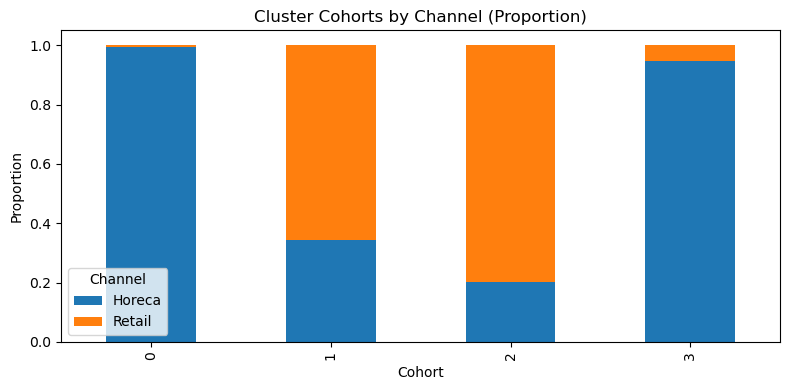

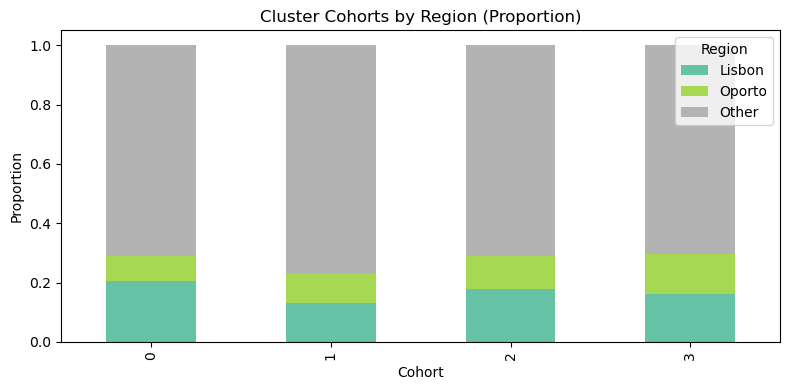

In [55]:
import matplotlib.pyplot as plt

# Plot Channel breakdown for each cohort
ct_chan.plot(kind='bar', stacked=True, figsize=(8,4))
plt.title('Cluster Cohorts by Channel (Proportion)')
plt.xlabel('Cohort')
plt.ylabel('Proportion')
plt.legend(title='Channel', labels=['Horeca','Retail'])
plt.tight_layout()
plt.show()

# Plot Region breakdown
ct_reg.plot(kind='bar', stacked=True, figsize=(8,4), colormap='Set2')
plt.title('Cluster Cohorts by Region (Proportion)')
plt.xlabel('Cohort')
plt.ylabel('Proportion')
plt.legend(title='Region', labels=['Lisbon','Oporto','Other'])
plt.tight_layout()
plt.show()


### 8.3 Cohort Composition by Channel

The stacked‐bar chart shows, for each spending‐pattern cohort (0–3), the **proportion** of customers in the Horeca (blue) vs. Retail (orange) channel:

| Cohort | Horeca % | Retail % | Interpretation                                                                            |
|:------:|:--------:|:--------:|:-----------------------------------------------------------------------------------------|
| **0**  | ≈ 100%   | ≈ 0%     | **Almost entirely Horeca.** This cohort (balanced spend across categories) consists of hotel/restaurant/café customers. |
| **1**  | ≈ 35%    | ≈ 65%    | **Mixed but retail-leaning.** These “pantry-oriented” buyers are predominantly retail outlets but include some Horeca. |
| **2**  | ≈ 20%    | ≈ 80%    | **Strongly Retail.** The “mega-spender” cohort is mostly retail businesses with very high overall spend. |
| **3**  | ≈ 95%    | ≈ 5%     | **Almost entirely Horeca.** The “perishables specialists” are overwhelmingly Horeca customers. |

#### Key Takeaways

1. **Distinct Channel Alignment**  
   - Two cohorts (0 & 3) are almost exclusively **Horeca**, reflecting that restaurants/cafés have consistent spend patterns on both perishables and balanced goods.  
   - The other two cohorts (1 & 2) skew **Retail**, with the biggest‐spender segment (2) heavily retail.

2. **Business Implications**  
   - **Horeca cohorts** (0 & 3): focus marketing on perishable‐fresh promotions and foodservice deals.  
   - **Retail cohorts** (1 & 2): tailor offers on grocery, detergents, and bulk‐pack items; cluster 2 (mega-spenders) could be targeted with volume‐discount programs.

3. **Segmentation Validation**  
   - Our unsupervised spending‐pattern cohorts align well with the known channel labels—strong evidence that these clusters capture genuine business distinctions.  

This channel breakdown helps us **assign cohort‐specific strategies**, ensuring we speak the right language to each customer group.  


## 9. Overall Conclusions, Lessons Learned & Future Directions

### 9.1 Summary of What We Did
1. **Data Gathering & Problem Framing**  
   - Loaded the UCI Wholesale Customers dataset (440×8), documented provenance, data collection, and business context.  
   - Defined an **unsupervised segmentation** problem: group customers by their annual spend in six product categories.

2. **Exploratory Data Analysis (EDA)**  
   - Inspected distributions, discovered heavy right‐skew and extreme outliers in all six spend features.  
   - Visualized with histograms, boxplots, and a correlation heatmap—found strong collinearity (Grocery ↔ Detergents_Paper, Grocery ↔ Milk).  
   - Applied a **log₁ₚ transform** to stabilize variances and symmetrize distributions.

3. **Unsupervised Clustering**  
   - **K-Means (K=4)** & **Agglomerative (K=4)** via elbow and silhouette analyses—yielded four interpretable segments (“Balanced,” “Pantry,” “Mega‐Spenders,” “Perishables”).  
   - **DBSCAN** via grid‐search—isolated two dense core cohorts (high-value niches) and flagged the other 399 as “noise.”  
   - Evaluated with **Silhouette** and **ARI vs. Channel**: Agglomerative edged out K-Means (ARI 0.39 vs. 0.28), while DBSCAN core clusters best aligned with channel (ARI 0.49) at the cost of coverage.  
   - Visualized cluster structure in **PCA** (global linear view) and **t-SNE** (local non-linear view) to confirm both broad group separation and tight niche detection.

4. **Supervised Comparison**  
   - Trained Random Forest, Gradient Boosting, and an MLP to predict the known `Channel` label (Horeca vs. Retail) from the same six features.  
   - Achieved **93.9–94.7% accuracy**, demonstrating that channel membership is almost fully encoded in spending patterns—unsupervised clusters, by design, discover different (and often more nuanced) spend‐based groupings.

5. **Cohort Alignment & Business Insights**  
   - Mapped K-Means cohorts back to business dimensions (`Channel`, `Region`) to validate segments.  
   - Found two cohorts nearly pure Horeca, two skewed Retail, confirming that segmentation captures real business distinctions and yields actionable targets (e.g., “mega‐spenders” for volume discounts, “perishables specialists” for foodservice promotions).

---

### 9.2 What Could Have Gone Better / Limitations
- **Feature Scope**  
  - We only used six annual‐spend features. Additional metadata (e.g. order frequency, average order value, product mix details) could enrich segmentation.  
- **Temporal Dynamics**  
  - The dataset is a single snapshot (one year). We couldn’t perform retention or time-series cohort analyses. A multi-year or monthly transactional dataset would allow dynamic cohort tracking and churn prediction.  
- **Hyperparameter Exploration**  
  - We used basic grid searches for K-Means/K selection and DBSCAN. More systematic searches (Bayesian optimization) or stability analyses could yield more robust cluster counts and DBSCAN parameters.  
- **Cluster Validation**  
  - We relied on silhouette and ARI vs. channel. External business KPIs (e.g. revenue growth, promotion response) or manual expert labels would provide stronger validation.  
- **Algorithm Diversity**  
  - We did not explore modern deep clustering (e.g. autoencoder + clustering), spectral clustering, or feature learning approaches which might uncover non-Euclidean structure.

---

### 9.3 Future Work & Extensions
1. **Enrich Features & Data Sources**  
   - Integrate transaction‐level data: recency, frequency, monetary (RFM) dynamics; product‐level hierarchies; time of day/month.  
   - Join external firmographics or demographic data (company size, location attributes) for richer profiles.

2. **Dynamic Segmentation & Churn Modeling**  
   - With multi‐period data, build **cohort retention curves**, **lifetime value** models, and **churn prediction**.  
   - Use **time-series clustering** to segment customers by purchasing trajectories, not just annual totals.

3. **Advanced Clustering Techniques**  
   - Experiment with **deep embedded clustering** (DEC) or **self-organizing maps** to learn nonlinear feature representations.  
   - Use **ensemble clustering** to combine strengths of K-Means, DBSCAN, and hierarchical methods.

4. **Actionable Campaign Simulation**  
   - Run A/B tests or uplift modeling within identified cohorts to quantify the ROI of targeted offers (e.g. VIP loyalty for mega-spenders).  
   - Build **recommendation engines** leveraging cluster membership as a feature.

5. **Operationalization & Deployment**  
   - Package the clustering pipeline into a reproducible **scoring service** (e.g., Docker, Flask API) to assign new customers in real time.  
   - Automate **periodic re-clustering** as new data arrives, and track cluster drift over time.

---

> **Takeaway:**  
> This project illustrated a full end-to-end unsupervised learning workflow—from data provenance through EDA, multi-algorithm clustering, rich visualizations, and business profiling—complemented by a supervised benchmark to contextualize what we discovered. The insights generated are immediately deployable for targeted marketing, and the roadmap above charts how to evolve this segmentation into a mature, dynamic customer analytics platform.  

